In [1]:
import pandas as pd
import numpy as np

# import helper.binance_api as ba
import helper.yahoo_api as ya

df_of_symbols_set = pd.read_excel('C:/Users/phata/Documents/GitHub/quant_tools/helper/set_symbol_list.xlsx')
list_of_symbols_set = df_of_symbols_set['symbol'].to_list()

In [2]:
def get_data_1d_SET(symbol: str): # only close
    series = ya.get_data_1d(symbol).close.rename(symbol)
    return series[series > 0] # Quick fix for negative prices
def get_df(li_symbols, int_start_year = None, int_end_year = None):
    df = pd.concat([get_data_1d_SET(symbol) for symbol in li_symbols], axis = 1)
    if int_start_year is not None: df = df[df.index.year >= int_start_year]
    if int_end_year is not None: df = df[df.index.year <= int_end_year]
    # st.session_state.df = df
    return df

In [34]:
# https://gist.github.com/wiso/ce2a9919ded228838703c1c7c7dad13b
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [88]:
li_symbols = ['TOP', 'DELTA', 'AOT', 'CPF', 'KBANK', 'TRUE', 'TTB', 'THG', 'ORI', 'THANI']

In [114]:
for delisted in ['IFEC', 'PRO', 'THL']:
    try: li_symbols.remove(delisted)
    except: pass
df = get_df(li_symbols).dropna()


In [115]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
import matplotlib.pyplot as plt
from pypfopt import plotting

In [103]:
cov_sample

,TOP,DELTA,AOT,CPF,KBANK,TRUE,TTB,THG,ORI,THANI
TOP,228.650776,716.591776,296.108201,92.225027,604.433288,10.448218,1.752298,14.663706,12.357305,17.668035
DELTA,716.591776,22563.041890,2663.638691,700.956158,2936.214808,4.271131,-26.565233,2404.076947,387.258341,161.959203
AOT,296.108201,2663.638691,713.940909,180.076129,935.366484,14.476513,-0.650336,45.823972,28.221959,41.583170
CPF,92.225027,700.956158,180.076129,104.052994,531.884075,-3.498928,-4.271001,-5.733884,2.153794,11.214972
KBANK,604.433288,2936.214808,935.366484,531.884075,3598.962244,-0.037818,-21.497884,150.455161,19.907339,58.564432
TRUE,10.448218,4.271131,14.476513,-3.498928,-0.037818,18.581153,3.119673,5.374117,-1.243710,0.761759
TTB,1.752298,-26.565233,-0.650336,-4.271001,-21.497884,3.119673,0.965633,0.489737,-0.102435,-0.133211
THG,14.663706,2404.076947,45.823972,-5.733884,150.455161,5.374117,0.489737,281.369037,27.098406,3.461650
ORI,12.357305,387.258341,28.221959,2.153794,19.907339,-1.243710,-0.102435,27.098406,8.503246,2.416196
THANI,17.668035,161.959203,41.583170,11.214972,58.564432,0.761759,-0.133211,3.461650,2.416196,2.484660


In [121]:
correlation_from_covariance(cov_sample)

,TOP,DELTA,AOT,CPF,KBANK,TRUE,TTB,THG,ORI,THANI
TOP,1.000000,-0.283817,0.405513,-0.631600,0.891197,0.807400,0.926767,0.067247,0.286898,0.397402
DELTA,-0.283817,1.000000,0.191808,0.220205,-0.194886,-0.251750,-0.359945,0.606312,0.635450,0.353726
AOT,0.405513,0.191808,1.000000,-0.135994,0.416227,0.428605,0.304564,0.470168,0.298861,0.510897
CPF,-0.631600,0.220205,-0.135994,1.000000,-0.661105,-0.624444,-0.690071,-0.145430,-0.203811,-0.260115
KBANK,0.891197,-0.194886,0.416227,-0.661105,1.000000,0.846093,0.916287,0.265702,0.388776,0.490462
TRUE,0.807400,-0.251750,0.428605,-0.624444,0.846093,1.000000,0.831148,0.304578,0.397229,0.413240
TTB,0.926767,-0.359945,0.304564,-0.690071,0.916287,0.831148,1.000000,0.076708,0.241579,0.293251
THG,0.067247,0.606312,0.470168,-0.145430,0.265702,0.304578,0.076708,1.000000,0.700678,0.387273
ORI,0.286898,0.635450,0.298861,-0.203811,0.388776,0.397229,0.241579,0.700678,1.000000,0.535842
THANI,0.397402,0.353726,0.510897,-0.260115,0.490462,0.413240,0.293251,0.387273,0.535842,1.000000


In [116]:
mu = mean_historical_return(df)
cov_shrinkage = CovarianceShrinkage(df).ledoit_wolf()
cov_sample = df.cov()

In [123]:
import plotly.express as px

fig = px.imshow(correlation_from_covariance(cov_sample),
                color_continuous_scale=px.colors.diverging.RdBu,
                color_continuous_midpoint=0)
fig.show()

In [142]:
ef = EfficientFrontier(mu, cov_shrinkage, weight_bounds=(None, None))

<AxesSubplot: xlabel='Volatility', ylabel='Return'>

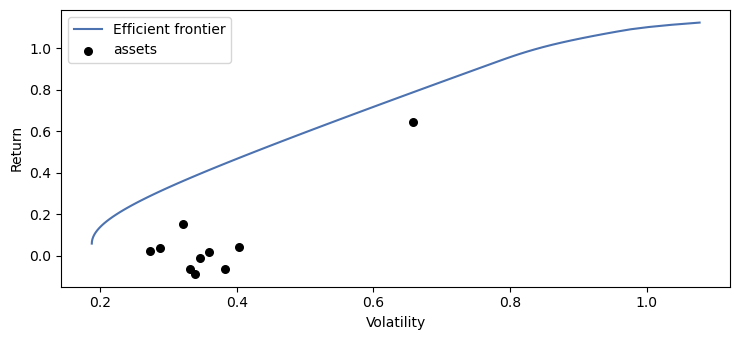

In [143]:
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
# plt.show()

In [144]:
import io
from PIL import Image
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.figure()
plt.plot([1, 2])

img_buf = io.BytesIO()
plt.savefig(img_buf, format='png')

im = Image.open(img_buf)
im.show(title="My Image")

img_buf.close()

<Figure size 750x350 with 0 Axes>